In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install torchaudio

Using device cuda
There are 35690 samples in the dataset.
torch.Size([1, 128, 431]) 0 64486.wav
tensor([[[7.8835e-02, 3.5330e-03, 9.6961e-04,  ..., 9.8750e-04,
          6.6312e-03, 2.4817e-02],
         [7.9581e-02, 1.1672e-01, 5.9067e-02,  ..., 7.1502e-03,
          1.4331e-02, 2.3679e-02],
         [8.2445e-02, 3.1057e-01, 1.5855e-01,  ..., 1.7720e-02,
          2.7647e-02, 2.2229e-02],
         ...,
         [2.1529e-02, 1.5580e-03, 1.4783e-03,  ..., 1.8572e-04,
          1.2477e-04, 2.3974e-04],
         [2.2270e-02, 6.1542e-04, 9.2903e-04,  ..., 9.0700e-05,
          6.5479e-05, 8.8746e-05],
         [2.4420e-02, 5.3192e-04, 1.1362e-03,  ..., 6.1496e-05,
          7.2237e-05, 6.0402e-05]]], device='cuda:0')


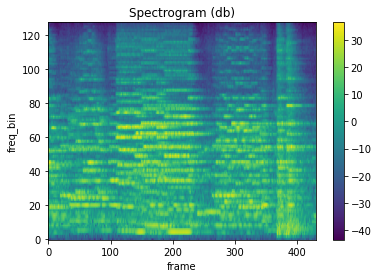

In [26]:
from torch.utils.data import Dataset
import pandas as pd
import torchaudio
import os
import torch
import matplotlib
import matplotlib.pyplot as plt
import librosa
import numpy as np

class DCASE_Dataset(Dataset):

  def __init__(self,
                 annotations_file,
                 audio_dir,
                 transformation,
                 target_sample_rate,
                 num_samples,
                 device):
    self.annotations = pd.read_csv(annotations_file)
    self.audio_dir = audio_dir
    self.device = device
    self.transformation = transformation.to(self.device)
    self.target_sample_rate = target_sample_rate
    self.num_samples = num_samples

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    audio_sample_path = self._get_audio_sample_path(index)
    label = self._get_audio_sample_label(index)
    filename = self._get_audio_sample_filename(index)
    signal, sr = torchaudio.load(audio_sample_path) 
    signal = signal.to(self.device)
    signal = self._resample_if_necessary(signal, sr)
    signal = self._mix_down_if_necessary(signal)
    signal = self._cut_if_necessary(signal)
    signal = self._right_pad_if_necessary(signal)
    signal = self.transformation(signal) 
    return signal, label, filename

  def _cut_if_necessary(self, signal):
      if signal.shape[1] > self.num_samples:
          signal = signal[:, :self.num_samples]
      return signal

  def _right_pad_if_necessary(self, signal):
      length_signal = signal.shape[1]
      if length_signal < self.num_samples:
          num_missing_samples = self.num_samples - length_signal
          last_dim_padding = (0, num_missing_samples)
          signal = torch.nn.functional.pad(signal, last_dim_padding)
      return signal

  def _resample_if_necessary(self, signal, sr):
    if sr != self.target_sample_rate:
        resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate).cuda()
        signal = resampler(signal)
    return signal

  def _mix_down_if_necessary(self, signal):
    if signal.shape[0] > 1: 
        signal = torch.mean(signal, dim=0, keepdim=True)
    return signal

  def _get_audio_sample_path(self, index):
    fold = f"{self.annotations.iloc[index, 1]}"
    path = os.path.join(self.audio_dir, fold, f"{self.annotations.iloc[index, 0]}.wav")
    return path

  def _get_audio_sample_label(self, index):
    return self.annotations.iloc[index, 2]

  def _get_audio_sample_filename(self, index):
    return f"{self.annotations.iloc[index, 0]}.wav"

if __name__ == "__main__":

  ANNOTATIONS_FILE = '/content/drive/My Drive/DCASE_Datasets/labels/combined_metadata.csv'
  AUDIO_DIR = '/content/drive/My Drive/DCASE_Datasets/audio/'
  SAMPLE_RATE = 22050
  DURATION = 10
  NUM_SAMPLES = 22050 * DURATION

  if torch.cuda.is_available():
    device = "cuda"
  else:
    device = "cpu"
  print(f"Using device {device}")

  mel_spectrogram = torchaudio.transforms.MelSpectrogram(
      sample_rate=SAMPLE_RATE,
      n_fft=1024,
      hop_length=512,
      n_mels=128
      )

  dcase_data = DCASE_Dataset(ANNOTATIONS_FILE, 
                             AUDIO_DIR, 
                             mel_spectrogram, 
                             SAMPLE_RATE,
                             NUM_SAMPLES,
                             device)

  print(f"There are {len(dcase_data)} samples in the dataset.")

  signal, label, filename = dcase_data[0]

  print(signal.shape, label, filename)

  print(signal)

  def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    spec = spec.cpu()
    spec = spec[0,:,:]
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
      axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

  plot_spectrogram(signal)


